### Steps to Take

1. Extracting Data
2. Defining Project Objective
3. Data Description & Cleaning
4. MVP: Applying & Validating the Algorithm
5. Data Wrangling & EDA
6. Improving Model
7. Results

In [1]:
# Libraries
import pandas as pd
import numpy as np
import glob
#import requests
#import re
#import math
#import random

# EDA & Preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Prediction Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Evaluation Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import pairwise_distances_argmin_min
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# Feature Ranking
#from sklearn.feature_selection import RFE

# Parameters
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

### 1. Extracting Data

The dataset is based on in-situ surveys carried out in five counties in Northern Kenya in November 2022 organized by United Nations Office for the Coordination of Humanitarian Affairs (OCHA). In order to combine the datasets, I previously standardized in Excel the questions across the five surveys. Additionally, I deleted (majorily) empty columns, columns that don't exist across all five datasets, and columns with identical/highly similar information. I also divided columns with more than one data point per cell in the respective amount of individual cells. <br>

The original datasource: https://data.humdata.org/dataset/kenya-displacement-baseline-multi-sectoral-location-assessment-iom-dtm

In [2]:
# getting a list of all Excel file paths in the directory
excel_files = glob.glob('/Users/ingaeumann/Documents/LERNEN/DATA Sciences/IRONHACK/Final Project/water-scarcity-projection/surveys/*.xlsx')

# initialising an empty list to store dataframes from each file
dataframes = []

# reading each Excel file into a dataframe and store it in the list
for file in excel_files:
    df = pd.read_excel(file, sheet_name = 1)
    # print("Column names for", file, ":", df.columns)  # Printing the column names
    dataframes.append(df)

# concatenating all dataframe in the list into a single dataframe
data = pd.concat(dataframes, ignore_index=True)

In [3]:
data.head()

,Date of Assessment,County,Sub-County,Type of Interview,Key responded Sex,Location Type,No. of Families/HHs in this sub location / Village unit,Are there absentees in the sub location/ village unit?,When did they leave the sub-location / village unit?,Number of Households,1st reason for departure,2nd reason for departure,3rd reason for departure,Are there Pastoralist drop out in the Sub location / village unit?,When did they drop the pastoral livestock production?,Number of Households 1,1st reason for dropping out,2nd reason for dropping out,3rd reason for dropping out,Are there Arrivals in the sub location/ village unit ?,When did they arrive in the sub-location / village?,Number of Households 2,Country majority arrived from (only for Kenyan National),"County from where, for majority","Sub-county from where, for majority",1st reason for departure from habitual residence,2nd reason for departure from habitual residence,3rd reason for departure from habitual residence,Are there Returnees in the sub location/village unit?,When did they arrive in the sub-location?,Number of Households 3,Country they returned from,"County they returned from, for majority",Sub-county they returned from for majority,1st reason for returning,2nd reason for returning,Where are the returnees living?,What is the first main livelihood options in your sub location?,What is the estimated no of households that depend on the first livelihood?,What is the second main livelihood options in your sub location?,What is the estimated no of households that depend on the second livelihood?,What is the third main livelihood options in your sub location?,What is the estimated no of households that depend on the third livelihood?,What are the challenges facing the sub location/ village unit in the last 1 year?,What are the challenges facing the sub location/ village unit in the last 1 year? 1,What are the challenges facing the sub location/ village unit in the last 1 year? 2,What are the Primary health concern in the sub location/ village unit?,What are the Primary health concern in the sub location/ village unit ? 1,What are the Primary health concern in the sub location/ village unit? 2,Is there a health facility in this sub location/ village unit?,"If there is a health facility, what is the main problem with the health service?",What is the structural status of the health facility?,What is the main water source for the farming and livestock rearing?,How many water sources are currently functional?,Where do most people of this settlement collect drinking water?,How long does it take to reach the nearest water source? (one-way),What is the average queue time for water?,What proportion of people in the sub location/ village unit have access water for drinking?,"What proportion of people in the sub location/village unit have access water for cooking, bathing and washing?",What problems do people face in accessing water?,Does the sub location/village unit have a water user committee (WASHCO)?,Who mainly supports the sub location/ village unit in maintaining the boreholes/taps/wells?,What problems does the community face when it comes to latrines?,What are the most common water treatment methods used,Is there an educational facility for children in this sub location/ village unit ?,Estimated number of students in the sub location/ village unit,Estimated number of school dropouts in the sub location/ village unit,What is the main safety concern with the current shelter?
0,2022-11-24 00:00:00,Marsabit,Moyale,Face-to-face interview,Male,Urban settlement or Town,1339.0,Yes,Before 2020,8.0,Ethinic Clashes,Resource-based conflict,NaN,Yes,2020 to 2022,3.0,Drought,Lack of water and pasture,NaN,Yes,Before 2020,7.0,Ethiopia,NaN,NaN,Ethinic Clashes,Resource-based conflict,Drought,Yes,NaN,2.0,Ethiopia,NaN,NaN,Wanted or needed to rejoin family,NaN,Host Community,Trade,200.0,Pastoralism,500.0,Employment (includes public and private sectors),1000.0,Environmental challenges,Safety and se

### 2. Defining Project Objective

**“Analysing and Evaluating Mobility in Northern Kenya”**

The aim is to identify the key factors influencing mobility in the North of Kenya. And specifically observe the role droughts play in the region.
I want to identify a number of features, therefore will apply unsupervised learning.

BACKGROUND: The ASAL region of Kenya has endured three severe droughts in the last decade (2010-2011, 2016-2017 and 2020-2022). The most recent drought (2020 - 2022) has also been the most severe and longest with widespread livelihood losses and massive displacement of populations.

### 3. Data Description & Cleaning

In [4]:
data.shape

(864, 68)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 68 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   Date of Assessment                                                                                              862 non-null    object 
 1   County                                                                                                          862 non-null    object 
 2   Sub-County                                                                                                      862 non-null    object 
 3   Type of Interview                                                                                               862 non-null    object 
 4   Key responded Sex                           

In [6]:
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.lower()
data.columns

Index(['date_of_assessment', 'county', 'sub-county', 'type_of_interview',
       'key_responded_sex', 'location_type',
       'no._of_families/hhs_in_this_sub_location_/_village_unit',
       'are_there_absentees_in_the_sub_location/_village_unit?',
       'when_did_they_leave_the_sub-location_/_village_unit?',
       'number_of_households', '1st_reason_for_departure',
       '2nd_reason_for_departure', '3rd_reason_for_departure',
       'are_there_pastoralist_drop_out_in_the_sub_location_/_village_unit?',
       'when_did_they_drop_the_pastoral_livestock_production?',
       'number_of_households_1', '1st_reason_for_dropping_out',
       '2nd_reason_for_dropping_out', '3rd_reason_for_dropping_out',
       'are_there_arrivals_in_the_sub_location/_village_unit_?',
       'when_did_they_arrive_in_the_sub-location_/_village?',
       'number_of_households_2',
       'country_majority_arrived_from_(only_for_kenyan_national)',
       'county_from_where,_for_majority',
       'sub-county_fro

**There is a number of columns that are not important for the defined objective:** <br>
- The characteristics of the person that was interviewed, the type of interview. <br>
- The county people arrived/returned from. Information on the sub-county is sufficient and more exact to observe and evaluate mobility. <br>
- The columns answering with a Yes/No whether people left or arrived in the location is also irrelevant, since there is another column stating the number of households that left/arrived. <br>
- For the analysis it is also irrelevant whether the arrivals/returnees are living in the host community or nearby, information on movements as well as reason(s) is sufficient.
- There is a number of columns dealing with pastoralism and access to drinking water in the region. Some of them factually deliver similar information, therefore a couple of them can be dropped without interfering with achieving the objective.
- The information on health can be reduced to concerns in order to tackle the objective.

In [7]:
data = data.drop(['type_of_interview', 'key_responded_sex', 'are_there_absentees_in_the_sub_location/_village_unit?', 'are_there_pastoralist_drop_out_in_the_sub_location_/_village_unit?', 'are_there_returnees_in_the_sub_location/village_unit?', 'are_there_arrivals_in_the_sub_location/_village_unit_?', 'when_did_they_arrive_in_the_sub-location?', 'county_from_where,_for_majority', 'county_they_returned_from,_for_majority', 'where_are_the_returnees_living?', 'what_problems_do_people_face_in_accessing_water?', 'what_is_the_main_water_source_for_the_farming_and_livestock_rearing?', 'where_do_most_people_of_this_settlement_collect_drinking_water?', 'does_the_sub_location/village_unit_have_a_water_user_committee_(washco)?', 'what_are_the_most_common_water_treatment_methods_used', 'who_mainly_supports_the_sub_location/_village_unit_in_maintaining_the_boreholes/taps/wells?', 'is_there_a_health_facility_in_this_sub_location/_village_unit?', 'if_there_is_a_health_facility,_what_is_the_main_problem_with_the_health_service?', 'what_is_the_structural_status_of_the_health_facility?', 'what_problems_does_the_community_face_when_it_comes_to_latrines?'], axis=1)

In [8]:
data = data.rename(columns={
    'date_of_assessment': 'assessment_date',
    'no._of_families/hhs_in_this_sub_location_/_village_unit': 'households_in_location',
    'when_did_they_leave_the_sub-location_/_village_unit?': 'departure_date',
    'number_of_households': 'households_departed',
    'when_did_they_drop_the_pastoral_livestock_production?': 'pastoralism_drop_date',
    'number_of_households_1': 'households_pastoralism_drop',
    '1st_reason_for_dropping_out': '1st_reason_to_drop',
    '2nd_reason_for_dropping_out': '2nd_reason_to_drop',
    '3rd_reason_for_dropping_out': '3rd_reason_to_drop',
    'when_did_they_arrive_in_the_sub-location_/_village?': 'arrival_date',
    'number_of_households_2': 'households_arrived',
    'country_majority_arrived_from_(only_for_kenyan_national)': 'country_arrived_from',
    'sub-county_from_where,_for_majority': 'sub-county_arrived_from',
    '1st_reason_for_departure_from_habitual_residence': '1st_reason_for_departure_from_origin',
    '2nd_reason_for_departure_from_habitual_residence': '2nd_reason_for_departure_from_origin',
    '3rd_reason_for_departure_from_habitual_residence': '3rd_reason_for_departure_from_origin',
    'number_of_households_3': 'households_returned',
    'country_they_returned_from': 'country_returned_from',
    'sub-county_they_returned_from_for_majority': 'sub-county_returned_from',
    'what_is_the_first_main_livelihood_options_in_your_sub_location?': 'livelihood_1',
    'what_is_the_estimated_no_of_households_that_depend_on_the_first_livelihood?': 'households_livelihood_1',
    'what_is_the_second_main_livelihood_options_in_your_sub_location?': 'livelihood_2',
    'what_is_the_estimated_no_of_households_that_depend_on_the_second_livelihood?': 'households_livelihood_2',
    'what_is_the_third_main_livelihood_options_in_your_sub_location?': 'livelihood_3',
    'what_is_the_estimated_no_of_households_that_depend_on_the_third_livelihood?': 'households_livelihood_3',
    'what_are_the_challenges_facing_the_sub_location/_village_unit_in_the_last_1_year?': '1st_challenge',
    'what_are_the_challenges_facing_the_sub_location/_village_unit_in_the_last_1_year?_1': '2nd_challenge',
    'what_are_the_challenges_facing_the_sub_location/_village_unit_in_the_last_1_year?_2': '3rd_challenge',
    'what_are_the_primary_health_concern_in_the_sub_location/_village_unit?': '1st_health_concern',
    'what_are_the_primary_health_concern_in_the_sub_location/_village_unit_?_1': '2nd_health_concern',
    'what_are_the_primary_health_concern_in_the_sub_location/_village_unit?_2': '3rd_health_concern',
    'how_many_water_sources_are_currently_functional?': 'functional_watersources',
    'how_long_does_it_take_to_reach_the_nearest_water_source?_(one-way)': 'watersource_distance',
    'what_is_the_average_queue_time_for_water?': 'water_queue_time',
    'what_proportion_of_people_in_the_sub_location/_village_unit_have_access_water_for_drinking?': 'percent_drinkingwater_access',
    'what_proportion_of_people_in_the_sub_location/village_unit_have_access_water_for_cooking,_bathing_and_washing?': 'percent_cookingwater_access',
    'is_there_an_educational_facility_for_children_in_this_sub_location/_village_unit_?': 'educational_facility',
    'estimated_number_of_students_in_the_sub_location/_village_unit': 'students',
    'estimated_number_of_school_dropouts_in_the_sub_location/_village_unit': 'school_dropouts',
    'what_is_the_main_safety_concern_with_the_current_shelter?': 'safety_concerns'
})
# data.columns

In [9]:
# reordering columns for better logic
data = data[['assessment_date', 'county', 'sub-county', 'location_type', 'households_in_location', 'households_departed',
             'departure_date', '1st_reason_for_departure', '2nd_reason_for_departure','3rd_reason_for_departure', 'households_pastoralism_drop',
             'pastoralism_drop_date', '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop', 'households_arrived', 'arrival_date',
             'country_arrived_from', 'sub-county_arrived_from', '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin',
             '3rd_reason_for_departure_from_origin', 'households_returned', 'country_returned_from', 'sub-county_returned_from', '1st_reason_for_returning', '2nd_reason_for_returning',
             'livelihood_1', 'households_livelihood_1', 'livelihood_2', 'households_livelihood_2', 'livelihood_3', 'households_livelihood_3', '1st_challenge',
             '2nd_challenge', '3rd_challenge', '1st_health_concern', '2nd_health_concern', '3rd_health_concern', 'functional_watersources', 
             'watersource_distance', 'water_queue_time', 'percent_drinkingwater_access', 'percent_cookingwater_access', 
             'educational_facility', 'students', 'school_dropouts', 'safety_concerns']]
# data.head(10)

In [10]:
data.shape

(864, 48)

In [11]:
# checking for duplicates
duplicates = data[data.duplicated(keep=False)]
duplicates

,assessment_date,county,sub-county,location_type,households_in_location,households_departed,departure_date,1st_reason_for_departure,2nd_reason_for_departure,3rd_reason_for_departure,households_pastoralism_drop,pastoralism_drop_date,1st_reason_to_drop,2nd_reason_to_drop,3rd_reason_to_drop,households_arrived,arrival_date,country_arrived_from,sub-county_arrived_from,1st_reason_for_departure_from_origin,2nd_reason_for_departure_from_origin,3rd_reason_for_departure_from_origin,households_returned,country_returned_from,sub-county_returned_from,1st_reason_for_returning,2nd_reason_for_returning,livelihood_1,households_livelihood_1,livelihood_2,households_livelihood_2,livelihood_3,households_livelihood_3,1st_challenge,2nd_challenge,3rd_challenge,1st_health_concern,2nd_health_concern,3rd_health_concern,functional_watersources,watersource_distance,water_queue_time,percent_drinkingwater_access,percent_cookingwater_access,educational_facility,students,school_dropouts,safety_concerns


In [12]:
# checking for NaNs
data.isna().sum()

assessment_date                           2
county                                    2
sub-county                                2
location_type                             2
households_in_location                    2
households_departed                     109
departure_date                          153
1st_reason_for_departure                153
2nd_reason_for_departure                370
3rd_reason_for_departure                538
households_pastoralism_drop              36
pastoralism_drop_date                    55
1st_reason_to_drop                       55
2nd_reason_to_drop                      141
3rd_reason_to_drop                      302
households_arrived                      100
arrival_date                            190
country_arrived_from                    189
sub-county_arrived_from                 233
1st_reason_for_departure_from_origin    190
2nd_reason_for_departure_from_origin    413
3rd_reason_for_departure_from_origin    541
households_returned             

Since I want to analyse the key mobility drivers in the region and the dataset is restricted to the North of Kenya, NaNs in location-related features don't concern me. Missing values in arrival, departure, or pastoralism drop date concern me more (indicating whether before or as a consequence of the intense drought from 2020-2022). Having in mind that here NaNs simply indicate no departures/pastoralism drop/arrival/return, I will replace those NaNs in all related features with '0'. There is a couple additional rows that are missing data related to the movement features, here I will impute the mode to replace the NaNs. <br>

Most relevant are high amount of NaNs in features related to motivational and circumstancial factors such as reasons to move, challenges, health concerns, water access, etc. Missing reasons I will replace with 'Other' to not bias the data. <br>

Problem is that even though survey questions were identical, in one of the counties (Garissa with 356 entries) only about 50% of them were asked/answered by the questionees. I do not want to loose these entries to have a complete picture of the region and to not reduce the dataset too much avoiding overfitting. To deal with the missing data from the survey carried out in Garissa county I will use proportional assignation. They can be predicted reasonably well by the data from other counties since the 5 counties face highly similar challenges.

In [13]:
data.dropna(subset=['assessment_date'], inplace=True)

In [14]:
# data.isna().sum()

In [15]:
data.loc[data['households_departed'].isna(), ['departure_date', '1st_reason_for_departure', '2nd_reason_for_departure', '3rd_reason_for_departure']] = '0'
data['households_departed'].fillna(0, inplace=True)
data.loc[data['households_pastoralism_drop'].isna(), ['pastoralism_drop_date', '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop']] = '0'
data['households_pastoralism_drop'].fillna(0, inplace=True)
data.loc[data['households_arrived'].isna(), ['arrival_date', 'country_arrived_from', 'sub-county_arrived_from', '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin', '3rd_reason_for_departure_from_origin']] = '0'
data['households_arrived'].fillna(0, inplace=True)
data.loc[data['households_returned'].isna(), ['country_returned_from', 'sub-county_returned_from', '1st_reason_for_returning', '2nd_reason_for_returning']] = '0'
data['households_returned'].fillna(0, inplace=True)

In [16]:
data['departure_date'].unique()

array(['Before 2020', '2020 to 2022', nan, '0', 'Before_2020',
       '2020_to_2022'], dtype=object)

In [17]:
data['pastoralism_drop_date'].unique()

array(['2020 to 2022', 'Before 2020', nan, '2020_to_2022', 'Before_2020',
       '0'], dtype=object)

In [18]:
data['arrival_date'].unique()

array(['Before 2020', '2020 to 2022', nan, 'Before_2020', '2020_to_2022',
       '0'], dtype=object)

In [19]:
data['departure_date'].fillna(data['departure_date'].mode()[0], inplace=True)
data['departure_date'] = data['departure_date'].replace({'Before_2020': 'Before 2020', '2020_to_2022': '2020 to 2022'})
data['pastoralism_drop_date'].fillna(data['pastoralism_drop_date'].mode()[0], inplace=True)
data['pastoralism_drop_date'] = data['pastoralism_drop_date'].replace({'Before_2020': 'Before 2020', '2020_to_2022': '2020 to 2022'})
data['arrival_date'].fillna(data['arrival_date'].mode()[0], inplace=True)
data['arrival_date'] = data['arrival_date'].replace({'Before_2020': 'Before 2020', '2020_to_2022': '2020 to 2022'})
data['arrival_date'].unique()

array(['Before 2020', '2020 to 2022', '0'], dtype=object)

In [20]:
columns_to_fill = ['1st_reason_for_departure', '2nd_reason_for_departure', '3rd_reason_for_departure',
                   '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop',
                   '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin', '3rd_reason_for_departure_from_origin',
                   '1st_reason_for_returning', '2nd_reason_for_returning']

for column in columns_to_fill:
    data[column].fillna('Other', inplace=True)

columns_to_fill = ['country_arrived_from', 'sub-county_arrived_from',
                   'country_returned_from', 'sub-county_returned_from']

for column in columns_to_fill:
    data[column].fillna('Other', inplace=True)

First I deal with the date column to unify format.

In [21]:
data['assessment_date'].unique()

array([Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-26 00:00:00'),
       Timestamp('2022-11-23 00:00:00'), Timestamp('2022-11-22 00:00:00'),
       Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-25 00:00:00'),
       Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-27 00:00:00'),
       Timestamp('2022-11-29 00:00:00'), Timestamp('2022-12-01 00:00:00'),
       Timestamp('2022-11-30 00:00:00'), '2023-01-16', '2023-01-17',
       '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-21',
       '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25',
       '2023-01-26', '2023-01-27', '2023-01-28',
       Timestamp('2022-10-26 00:00:00'), Timestamp('2022-10-27 00:00:00'),
       Timestamp('2022-10-28 00:00:00'), Timestamp('2022-10-29 00:00:00'),
       Timestamp('2022-10-30 00:00:00'), Timestamp('2022-10-24 00:00:00'),
       Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-01 00:00:00'),
       Timestamp('2022-11-02 00:00:00'), Timestamp('2022-11-13 00:00:00'),
      

In [22]:
# turning all rows into timestamp format
data['assessment_date'] = pd.to_datetime(data['assessment_date'])
#extracting the date only from each timestamp
data['assessment_date'] = data['assessment_date'].dt.date

Now, I am checking categories in all of the categorical columns for unification and before applying any imputation method to fill NaNs.

In [23]:
data['county'].unique()
# data['sub-county'].unique()
# data['location_type'].unique()
# data['1st_reason_for_departure'].unique()
# data['2nd_reason_for_departure'].unique()
# data['3rd_reason_for_departure'].unique()
# data['1st_reason_to_drop'].unique()
# data['2nd_reason_to_drop'].unique()
# data['3rd_reason_to_drop'].unique()
# data['country_arrived_from'].unique()
# data['sub-county_arrived_from'].unique()
# data['1st_reason_for_departure_from_origin'].unique()
# data['2nd_reason_for_departure_from_origin'].unique()
# data['3rd_reason_for_departure_from_origin'].unique()
# data['country_returned_from'].unique()
# data['sub-county_returned_from'].unique()# data['1st_reason_for_returning'].unique()
# data['2nd_reason_for_returning'].unique()
# data['livelihood_1'].unique()
# data['livelihood_2'].unique()
# data['livelihood_3'].unique()
# data['1st_challenge'].unique()
# data['2nd_challenge'].unique()
# data['3rd_challenge'].unique()
# data['1st_health_concern'].unique()
# data['2nd_health_concern'].unique()
# data['3rd_health_concern'].unique()
# data['watersource_distance'].unique()
# data['water_queue_time'].unique()
# data['percent_drinkingwater_access'].unique()
# data['percent_cookingwater_access'].unique()
# data['educational_facility'].unique()
# data['safety_concerns'].unique() 

array(['Marsabit', 'Samburu', 'Isiolo', 'Turkana', 'Garissa'],
      dtype=object)

Almost all the categorical columns have misspelling, differing spelling and unclear categories. I unify.

In [24]:
def clean_category(cat):
    if isinstance(cat, str):
        if cat in ['0', 'Ethinic Clashes', 'Ethinic_Clashes']:
            if cat == '0':
                return 'Other'
            else:
                return 'Ethnic Clashes'
        else:
            return cat.replace('_', ' ').title()
    else:
        return cat  # returning NaN as is

categorical_columns = data.select_dtypes(include=['object']).columns

for column in categorical_columns:
    data[column] = data[column].map(clean_category)

The categories of categorical columns are unified now. I proceed with imputation.

In [25]:
# separating Garissa and other county data
data_garissa = data[data['county'] == 'Garissa']
data_non_garissa = data[data['county'] != 'Garissa']

# filtering rows with NaNs in Garissa county data
data_garissa_nan = data_garissa[data_garissa.isna().any(axis=1)]

# for each row with NaN in the Garissa dataset, finding a similar row in the non-Garissa dataset and use it to fill NaNs.
for i in data_garissa_nan.index:
    similarities = data_non_garissa.apply(lambda row: (row == data_garissa_nan.loc[i]).mean(), axis=1)
    most_similar_index = similarities.idxmax()
    data_garissa_nan.loc[i] = data_garissa_nan.loc[i].fillna(data_non_garissa.loc[most_similar_index])

# concatenating the imputed and non-imputed Garissa data
data_garissa_filled = pd.concat([data_garissa_nan, data_garissa.dropna()], axis=0)

In [26]:
# concatenating the two datasets
data_cleaned = pd.concat([data_garissa_filled, data_non_garissa])

I change a couple of categorical columns to numerical since their content is of numerical nature only expressed in words.

In [27]:
# writing a dictionary for the value replacement
watersource_distance_dict = {
    '21-30 Minute Walk': 25.5,
    '31-45 Minute Walk': 38,
    'More Than 45-Minute Walk': 50,
    'Less Than 20-Minute Walk': 10,
    np.nan: np.nan
}

water_queue_time_dict = {
    'Less Than 20-Minute': 10,
    '21-30 Minute': 25.5,
    'More Than 45-Minute': 50,
    '31-45 Minute': 38,
    np.nan: np.nan
}

percentage_dict = {
    'About Half Around 50Pc': 50,
    'A Few Around 25Pc': 25,
    'Most Around 75Pc': 75,
    'Everyone Around 100Pc': 100,
    'Nobody Around 0Pc': 0,
    'Dont Know': np.nan,
    np.nan: np.nan
}

# replacing the values in the columns
data_cleaned['watersource_distance'] = data_cleaned['watersource_distance'].map(watersource_distance_dict)
data_cleaned['water_queue_time'] = data_cleaned['water_queue_time'].map(water_queue_time_dict)
data_cleaned['percent_drinkingwater_access'] = data_cleaned['percent_drinkingwater_access'].map(percentage_dict)
data_cleaned['percent_cookingwater_access'] = data_cleaned['percent_cookingwater_access'].map(percentage_dict)


Now I look at the numerical columns. I turn float into int, since there are no half households, students, watersources...

In [28]:
numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    # handeling missing values
    data_cleaned[col] = data_cleaned[col].fillna(0)
    # rounding to the nearest integer
    data_cleaned[col] = data_cleaned[col].round()
    # converting to integer
    data_cleaned[col] = data_cleaned[col].astype(int)

There are now a couple of NaNs remaining since some interviewees did not voice a second or third concern on challenges or health. I turn these NaNs into 'No Additional Challenge'. 

In [29]:
columns_to_fill = ['2nd_challenge', '3rd_challenge', '2nd_health_concern', '3rd_health_concern']

for column in columns_to_fill:
    data_cleaned[column] = data_cleaned[column].fillna('No Additional Challenge')

In [30]:
data_cleaned.isna().sum()

assessment_date                         0
county                                  0
sub-county                              0
location_type                           0
households_in_location                  0
households_departed                     0
departure_date                          0
1st_reason_for_departure                0
2nd_reason_for_departure                0
3rd_reason_for_departure                0
households_pastoralism_drop             0
pastoralism_drop_date                   0
1st_reason_to_drop                      0
2nd_reason_to_drop                      0
3rd_reason_to_drop                      0
households_arrived                      0
arrival_date                            0
country_arrived_from                    0
sub-county_arrived_from                 0
1st_reason_for_departure_from_origin    0
2nd_reason_for_departure_from_origin    0
3rd_reason_for_departure_from_origin    0
households_returned                     0
country_returned_from             

In [31]:
# dropping the last NaN row remaining
data_cleaned.dropna(inplace=True)

In [32]:
data_cleaned.shape

(861, 48)

In [33]:
data_cleaned.head()

,assessment_date,county,sub-county,location_type,households_in_location,households_departed,departure_date,1st_reason_for_departure,2nd_reason_for_departure,3rd_reason_for_departure,households_pastoralism_drop,pastoralism_drop_date,1st_reason_to_drop,2nd_reason_to_drop,3rd_reason_to_drop,households_arrived,arrival_date,country_arrived_from,sub-county_arrived_from,1st_reason_for_departure_from_origin,2nd_reason_for_departure_from_origin,3rd_reason_for_departure_from_origin,households_returned,country_returned_from,sub-county_returned_from,1st_reason_for_returning,2nd_reason_for_returning,livelihood_1,households_livelihood_1,livelihood_2,households_livelihood_2,livelihood_3,households_livelihood_3,1st_challenge,2nd_challenge,3rd_challenge,1st_health_concern,2nd_health_concern,3rd_health_concern,functional_watersources,watersource_distance,water_queue_time,percent_drinkingwater_access,percent_cookingwater_access,educational_facility,students,school_dropouts,safety_concerns
508,2022-09-12,Garissa,Balambala,Village,230,25,2020 To 2022,Drought,Resource-Based Conflict,Other,90,2020 To 2022,Drought,Resource-Based Conflict,Other,15,2020 To 2022,Kenya,Lagdera,Drought,Resource-Based Conflict,Other,10,Kenya,Lagdera,Drought,Resource-Based Conflict,Farming,1750,Pastoralism,500,Trade,33,Safety And Security,Lack Of Food And Water,Resource Based Conflict,Malaria,Tuberculosis,Diarrhea,3,50,50,50,50,Yes,288,6,Weather
509,2022-09-13,Garissa,Balambala,Village,35,31,2020 To 2022,Drought,Resource-Based Conflict,Other,27,2020 To 2022,Drought,Resource-Based Conflict,Other,40,2020 To 2022,Kenya,Lagdera,Drought,Resource-Based Conflict,Other,15,Kenya,Lagdera,Drought,Resource-Based Conflict,Farming,1750,Pastoralism,500,Trade,33,Safety And Security,Lack Of Food And Water,Resource Based Conflict,Malaria,Tuberculosis,Diarrhea,3,50,50,50,50,Yes,288,6,Weather
510,2022-09-12,Garissa,Ijara,Village,400,10,2020 To 2022,Drought,Resource-Based Conflict,Other,1000,2020 To 2022,Drought,Other,Resource-Based Conflict,190,2020 To 2022,Kenya,Lamu/West,Drought,Resource-Based Conflict,Other,500,Kenya,Lamu/West,Drought,Other,Pastoralism,700,Agro Pastoralism,300,Trade,250,Environmental Challenges,Loss Of Livelihood,Resource Based Conflict,Malaria,Pneumonia,Diarrhea,2,38,38,75,50,Yes,630,115,Lack Of Privacy
511,2022-09-16,Garissa,Fafi,Village,200,30,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,30,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,2020 To 2022,Kenya,Lagdera,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,40,Kenya,Fafi,Drought,Resource-Based Conflict,Pastoralism,400,Other,200,Trade,5,Safety And Security,Resource Based Conflict,Lack Of Food And Water,Malaria,Pneumonia,Diarrhea,2,50,38,25,25,No,0,0,Weather
512,2022-09-16,Garissa,Fafi,Village,200,100,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,2020 To 2022,Kenya,Fafi,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,Kenya,Fafi,Drought,Resource-Based Conflict,Pastoralism,500,Farming,50,Employment (Includes Public And Private Sectors),80,Safety And Security,No Additional Challenge,No Additional Challenge,Pneumonia,No Additional Challenge,No Additional Challenge,3,38,10,25,25,Yes,1800,200,Lack Of Security


In [34]:
data_cleaned.to_csv('data_cleaned.csv')

### 4. MVP: Applying & Validating the Algorithm

For comparison I first apply the clustering without previously scaling the features.

In [35]:
# selecting the columns that most likely are drivers for mobility in the region

# categorical columns to convert
cat_cols = [
    '1st_reason_for_departure', '2nd_reason_for_departure', '3rd_reason_for_departure', 
    '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop', 
    '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin', 
    '3rd_reason_for_departure_from_origin',
    '1st_reason_for_returning', '2nd_reason_for_returning',
    '1st_challenge', '2nd_challenge', '3rd_challenge',
    '1st_health_concern', '2nd_health_concern', '3rd_health_concern', 
    'safety_concerns', 'educational_facility'
]

# numerical columns
num_cols = ['functional_watersources', 'watersource_distance', 'water_queue_time', 
            'percent_drinkingwater_access', 'percent_cookingwater_access']

# applying Label Encoder to categorical columns
for col in cat_cols:
    data_cleaned[col] = LabelEncoder().fit_transform(data_cleaned[col])

# concatenating categorical and numerical features
reasons_for_mobility = pd.concat([data_cleaned[cat_cols], data_cleaned[num_cols]], axis=1)

# running KMeans
kmeans = KMeans(n_clusters=6, random_state=42).fit(reasons_for_mobility)
clusters = kmeans.predict(reasons_for_mobility)

# turning clusters into a dataframe
reasons_for_mobility['cluster'] = clusters

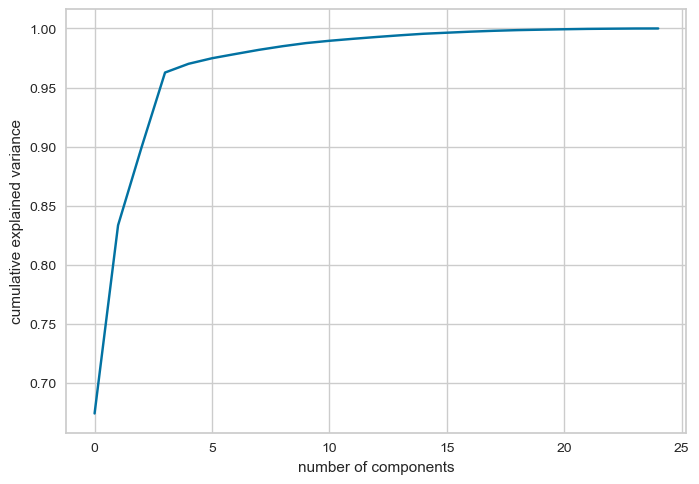

In [36]:
# checking the variance ratio to find the best number of PCA (the best is 3)
pca = PCA().fit(reasons_for_mobility)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [37]:
# adding those columns that are interesting to the dataframe
new_columns = {
    'county': data_cleaned['county'], 
    'sub-county': data_cleaned['sub-county'], 
    'households_in_location': data_cleaned['households_in_location'],
    'cluster': clusters
}

for col_name, col_data in new_columns.items():
    reasons_for_mobility.insert(0, col_name, col_data)

reasons_for_mobility.head()

ValueError: cannot insert cluster, already exists

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

labels = np.unique(clusters)

for i in labels:
    ax.scatter(reduced_data[clusters == i , 0], 
               reduced_data[clusters == i , 1], 
               reduced_data[clusters == i , 2], 
               label = i)
    
plt.legend()
ax.set_title('kmeans clustering')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')
plt.show()